In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.cosmology import FlatLambdaCDM 
from astropy.table import Table
import astropy.units as u

import sys
sys.path.append("../utility_functions/")
from objectProperties import ObjectProperties

In [2]:
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

In [3]:
#Load the properties of the BHDs
op = ObjectProperties()

In [4]:
#Load the seeing values. 
seeing = Table.read("../../analysis_v4/All_seeing_values.txt", format='ascii')
seeing.rename_column("col1", "WID")
seeing.rename_column("col2", "Band")
seeing.rename_column("col3", "FWHM")
seeing.rename_column("col4", "filename")

In [5]:
#Set the angle and pfrac limits for each object. 
plot_lims = dict()
plot_lims['W0019-1046'] = {'R_SPECIAL':{'pfrac':{'min': 3.,'max':10.},'pangle':{'min':0,'max':180}}}
plot_lims['W0204-0506'] = {'R_SPECIAL':{'pfrac':{'min':15.,'max':35.},'pangle':{'min':0,'max':180}}}
plot_lims['W0220+0137'] = {'R_SPECIAL':{'pfrac':{'min':10.,'max':20.},'pangle':{'min':0,'max':180}}}
plot_lims['W0831+0140'] = {'R_SPECIAL':{'pfrac':{'min': 5.,'max':15.},'pangle':{'min':0,'max':180}}}
plot_lims['W0116-0505'] = {
    'R_SPECIAL':{'pfrac':{'min': 8.,'max':18.},'pangle':{'min':0,'max':180}},
    'I_BESS'   :{'pfrac':{'min':10.,'max':20.},'pangle':{'min':0,'max':180}},
    'v_HIGH'   :{'pfrac':{'min': 5.,'max':15.},'pangle':{'min':0,'max':180}}
}

In [6]:
texify_band = {'R_SPECIAL': r'$R_{\rm Special}$', 'I_BESS': r'$I_{\rm Bessel}$', 'v_HIGH': r'$v_{\rm High}$'}

In [7]:
op.__dict__

{'wids': ['W0019-1046',
  'W0204-0506',
  'W0220+0137',
  'W0831+0140',
  'W0116-0505'],
 'filters': {'W0019-1046': ['R_SPECIAL'],
  'W0204-0506': ['R_SPECIAL'],
  'W0220+0137': ['R_SPECIAL'],
  'W0831+0140': ['R_SPECIAL'],
  'W0116-0505': ['R_SPECIAL', 'I_BESS', 'v_HIGH']},
 'script_folder': '/Volumes/PortableSSD/Impol_BHDs_repo/plots/utility_functions',
 'pfrac': {'W0019-1046': {'R_SPECIAL': 6.35},
  'W0204-0506': {'R_SPECIAL': 24.72},
  'W0220+0137': {'R_SPECIAL': 13.66},
  'W0831+0140': {'R_SPECIAL': 7.45},
  'W0116-0505': {'R_SPECIAL': 11.11, 'I_BESS': 14.36, 'v_HIGH': array(9.62)}},
 'epfrac': {'W0019-1046': {'R_SPECIAL': 0.79},
  'W0204-0506': {'R_SPECIAL': 0.66},
  'W0220+0137': {'R_SPECIAL': 0.39},
  'W0831+0140': {'R_SPECIAL': 0.4},
  'W0116-0505': {'R_SPECIAL': 0.22, 'I_BESS': 0.43, 'v_HIGH': array(0.38)}},
 'z': {'W0019-1046': 1.641,
  'W0116-0505': 3.173,
  'W0204-0506': 2.099307,
  'W0220+0137': 3.122,
  'W0831+0140': 3.888}}

In [8]:
def make_plot(objects, blurr_PSF_FWHM=None, snr_stack_lim=5.0, size=20, bands=["R_SPECIAL"], output_fname=None, figsize=(40,18)):

    #folder = "../../Resolved_Polarization_v3/stamps_blurred_1.0"
    #blurr_PSF_FWHM = 1.0
    # if blurr_PSF_FWHM is None:
    #     folder = "../../Resolved_Polarization_v3/stamps"
    # else:
    #     folder = "../../Resolved_Polarization_v3/stamps_blurred_{:.1f}".format(blurr_PSF_FWHM)
    if blurr_PSF_FWHM is None:
        folder = "../../Resolved_Polarization_v5/stamps"
    else:
        folder = "../../Resolved_Polarization_v5/stamps_blurred_{:.1f}".format(blurr_PSF_FWHM)

    #Load the pol images. 
    ims = dict()
    for obj in objects:
        ims[obj] = dict()
        for band in bands:
            ims[obj][band] = dict()
            for imtype in ["pfrac","pangle","stack"]:
                if obj!="W0116-0505" or band!="v_HIGH":
                    ims[obj][band][imtype] = fits.open("{}/{}.{}.All.{}.fits".format(folder,obj,band,imtype))
                else:
                    ims[obj][band][imtype] = fits.open("{}/{}.{}.3564847.60143.{}.fits".format(folder,obj,band,imtype))
                if imtype=='pfrac':
                    ims[obj][band][imtype][0].data *= 100

    #Mask based on the stack image. 
    for obj in objects:
        for band in bands:
            _, _, rms = sigma_clipped_stats(ims[obj][band]['stack'][0].data, sigma=3.0)
            pmask = np.where(ims[obj][band]['stack'][0].data<snr_stack_lim*rms, True, False)
            ims[obj][band]['pfrac'][0].data[pmask] = np.nan
            ims[obj][band]['pangle'][0].data[pmask] = np.nan

    #Make the plot  
    pixscale = 0.126*2

    fig, axs = plt.subplots(2, len(objects)*len(bands), figsize=figsize, sharex=True, sharey=True, squeeze=False)
    plt.subplots_adjust(wspace=0., hspace=0.)
    for ax in axs.flat:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])

    ix1 = int(ims[objects[0]][bands[0]]['pfrac'][0].data.shape[1]/2 - size/2)
    ix2 = int(ims[objects[0]][bands[0]]['pfrac'][0].data.shape[1]/2 + size/2 * 1.3)
    iy1 = int(ims[objects[0]][bands[0]]['pfrac'][0].data.shape[0]/2 + size/2)
    iy2 = int(ims[objects[0]][bands[0]]['pfrac'][0].data.shape[0]/2 - size/2)

    cmaps = {'pfrac':'plasma_r', 'pangle':'hsv'}

    for i, obj in enumerate(objects):
        for j, band in enumerate(bands):
            for k, imtype in enumerate(['pfrac','pangle']):
                cm = axs[k,i+j].imshow(ims[obj][bands[0]][imtype][0].data[iy1:iy2:-1,ix1:ix2], vmin=plot_lims[obj][band][imtype]['min'], vmax=plot_lims[obj][band][imtype]['max'], cmap=cmaps[imtype])

                cax = inset_axes(axs[k,i+j], width="5%", height="90%", loc='right') 
                cbar = fig.colorbar(cm, cax=cax, orientation='vertical')
                cbar.ax.tick_params(labelsize=20)
                if imtype=='pfrac':
                    cbar.set_label(label=r'Polarization Fraction $P~(\%)$', fontsize=28)
                else:
                    cbar.set_label(label=r'Polarization Angle $\chi~(\rm deg)$', fontsize=28)
                cax.yaxis.set_ticks_position('left')
                cax.yaxis.set_label_position('left')

            #Object label
            axs[0,i+j].text(0.05, 0.9, obj, transform=axs[0,i+j].transAxes, fontsize=40, weight='bold')
            axs[0,i+j].text(0.05, 0.75, texify_band[band], transform=axs[0,i+j].transAxes, fontsize=36, weight='bold')

            #Add a label about the smoothing if any has been used.
            if blurr_PSF_FWHM is None:
                blurr_label = "No smoothing"
            else:
                blurr_label = "{:.1f}\" smoothing".format(blurr_PSF_FWHM)
            axs[0,i+j].text(0.05, 0.83, blurr_label, transform=axs[0,i+j].transAxes, fontsize=28)

            #Beam size
            beam_FWHM = np.max(seeing['FWHM'][(seeing['WID']==obj) & (seeing['Band']==band)])
            if blurr_PSF_FWHM is not None:
                beam_FWHM = (beam_FWHM**2 + blurr_PSF_FWHM**2)**0.5
            for k in [0,1]:
                beam  = plt.Circle((size*0.15,size*0.8),beam_FWHM/2/pixscale, color='k', fill=False)
                axs[k,i+j].add_patch(beam)

            # #10kpc bar
            # bar_size = (10*u.kpc/cosmo.angular_diameter_distance(z[obj]))*u.rad
            # bar_size_pix = bar_size.to(u.arcsec).value / pixscale
            # for k in [0,1]:
            #     axs[k,i+j].errorbar([size*0.75],[size*0.9],xerr=[bar_size_pix/2.], fmt='none', capsize=10.0)
            #     axs[k,i+j].text(size*0.75,size*0.9,"10 kpc",ha='center',va='bottom', fontsize=26)

            #1" bar
            bar_size = 1.0*u.arcsec
            bar_size_pix = bar_size.to(u.arcsec).value / pixscale
            for k in [0,1]:
                axs[k,i+j].errorbar([size*0.75],[size*0.9],xerr=[bar_size_pix/2.], fmt='none', capsize=10.0)
                axs[k,i+j].text(size*0.75,size*0.9,"1\"",ha='center',va='bottom', fontsize=26)

    #fig.tight_layout()
    plt.show()
    if output_fname is not None:
        fig.savefig(output_fname, dpi=200, bbox_inches='tight')
    return 

## New HDs

These are all the HDs without previous R_Special observations

In [9]:
objects = [
    "W0019-1046",
    "W0204-0506",
    "W0220+0137",
    "W0831+0140",
]
bands = ["R_SPECIAL"]

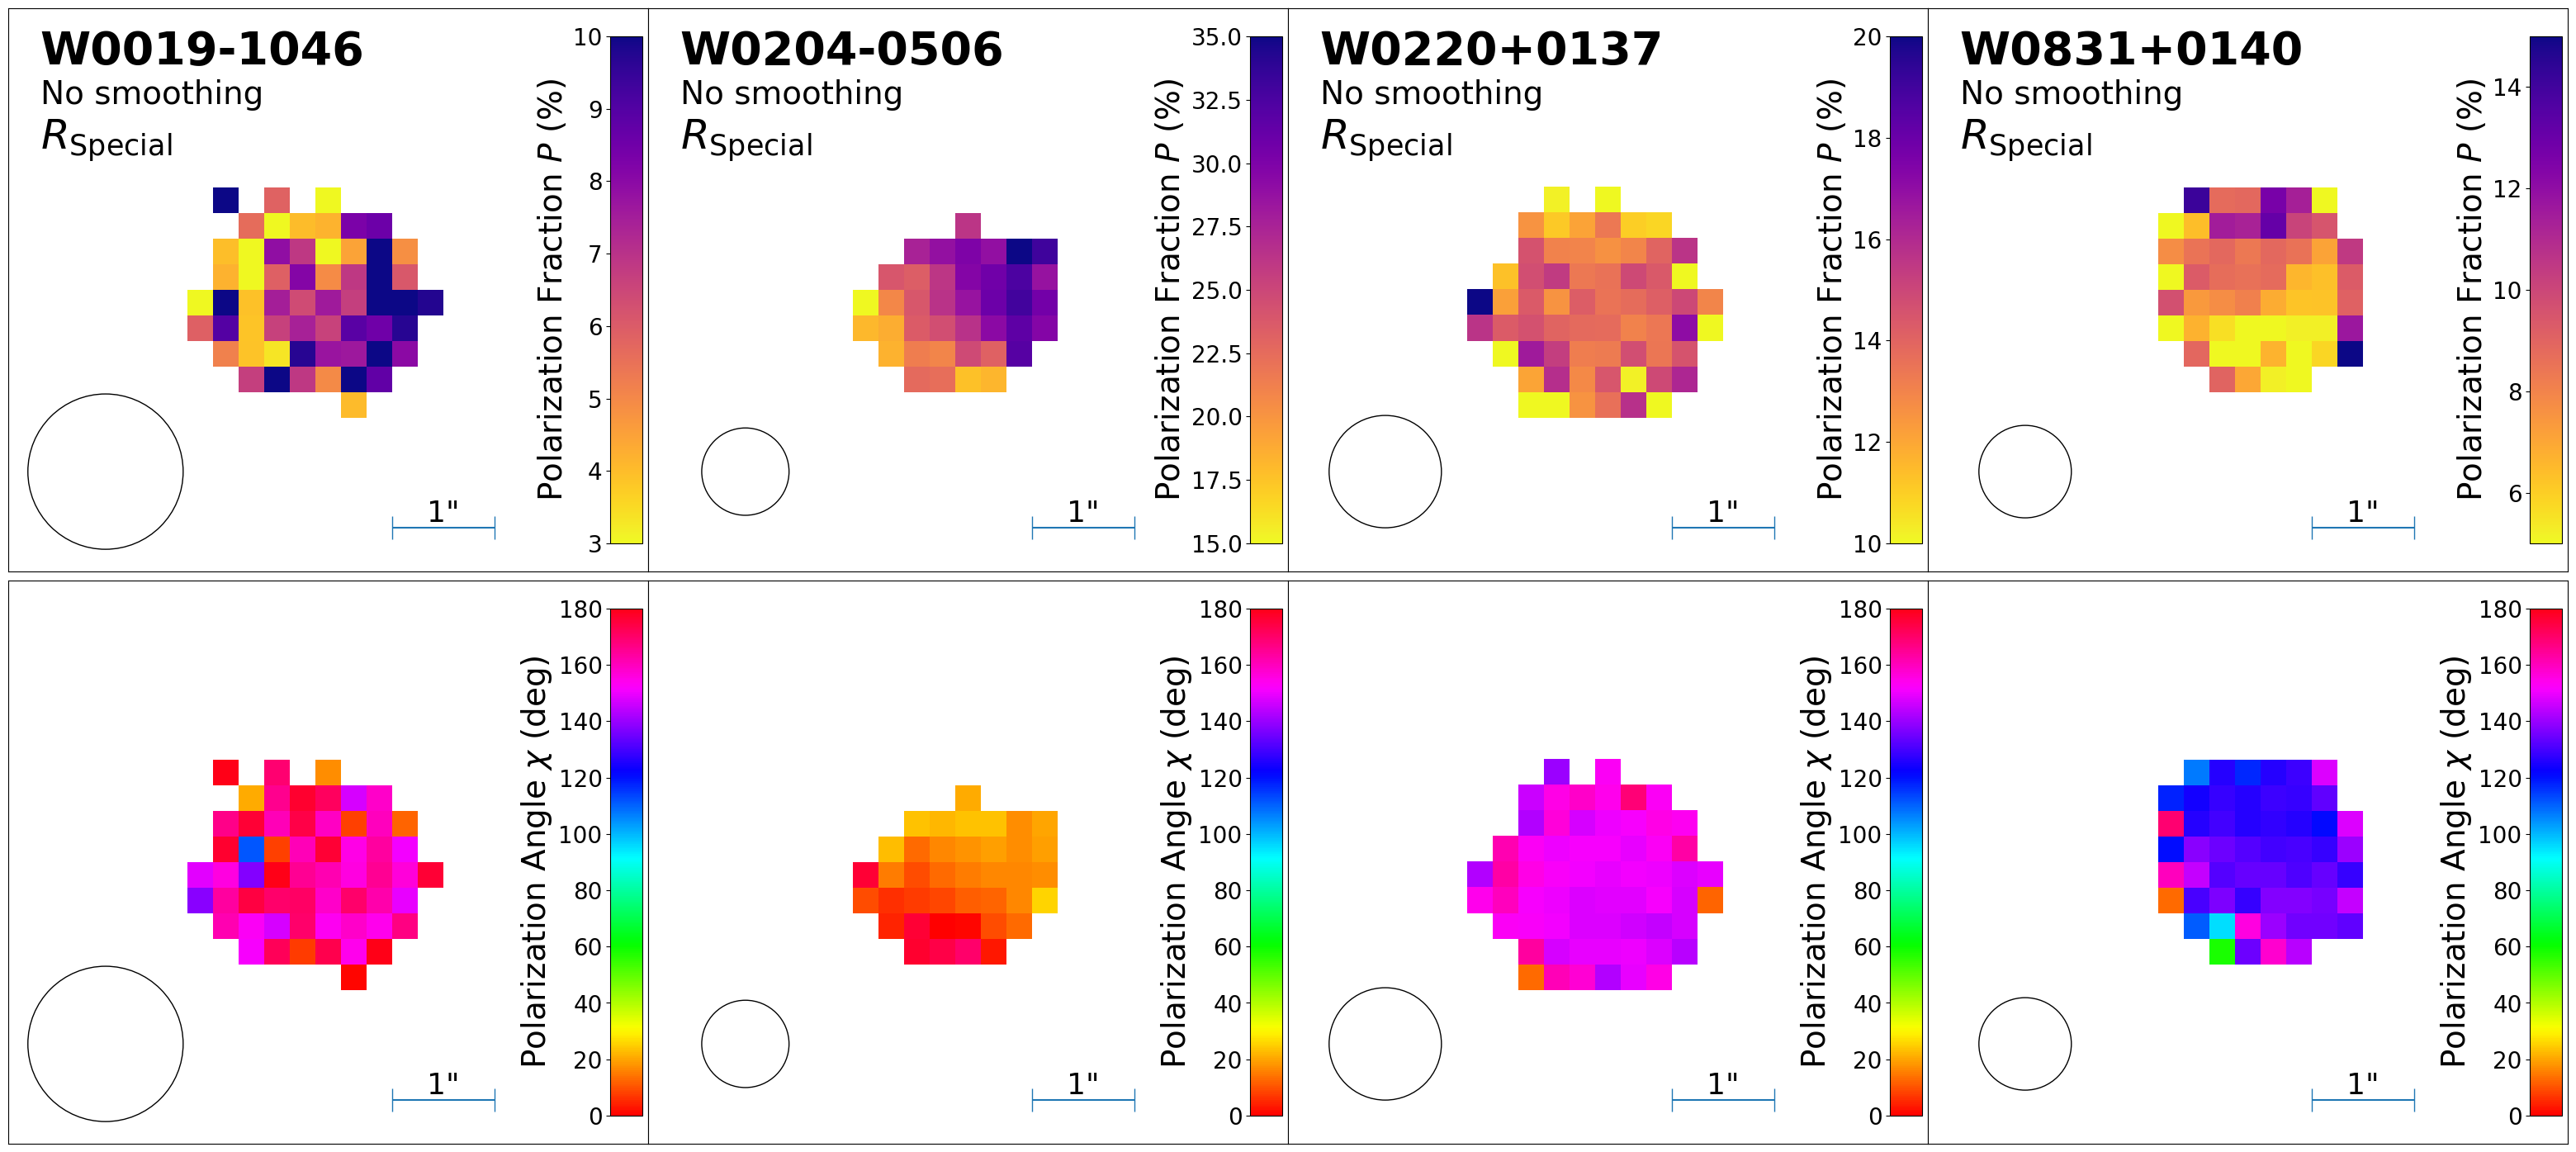

In [10]:
make_plot(objects, size=22, output_fname="Original_Resolution_new_HDs_2D_pol.png", bands=bands)

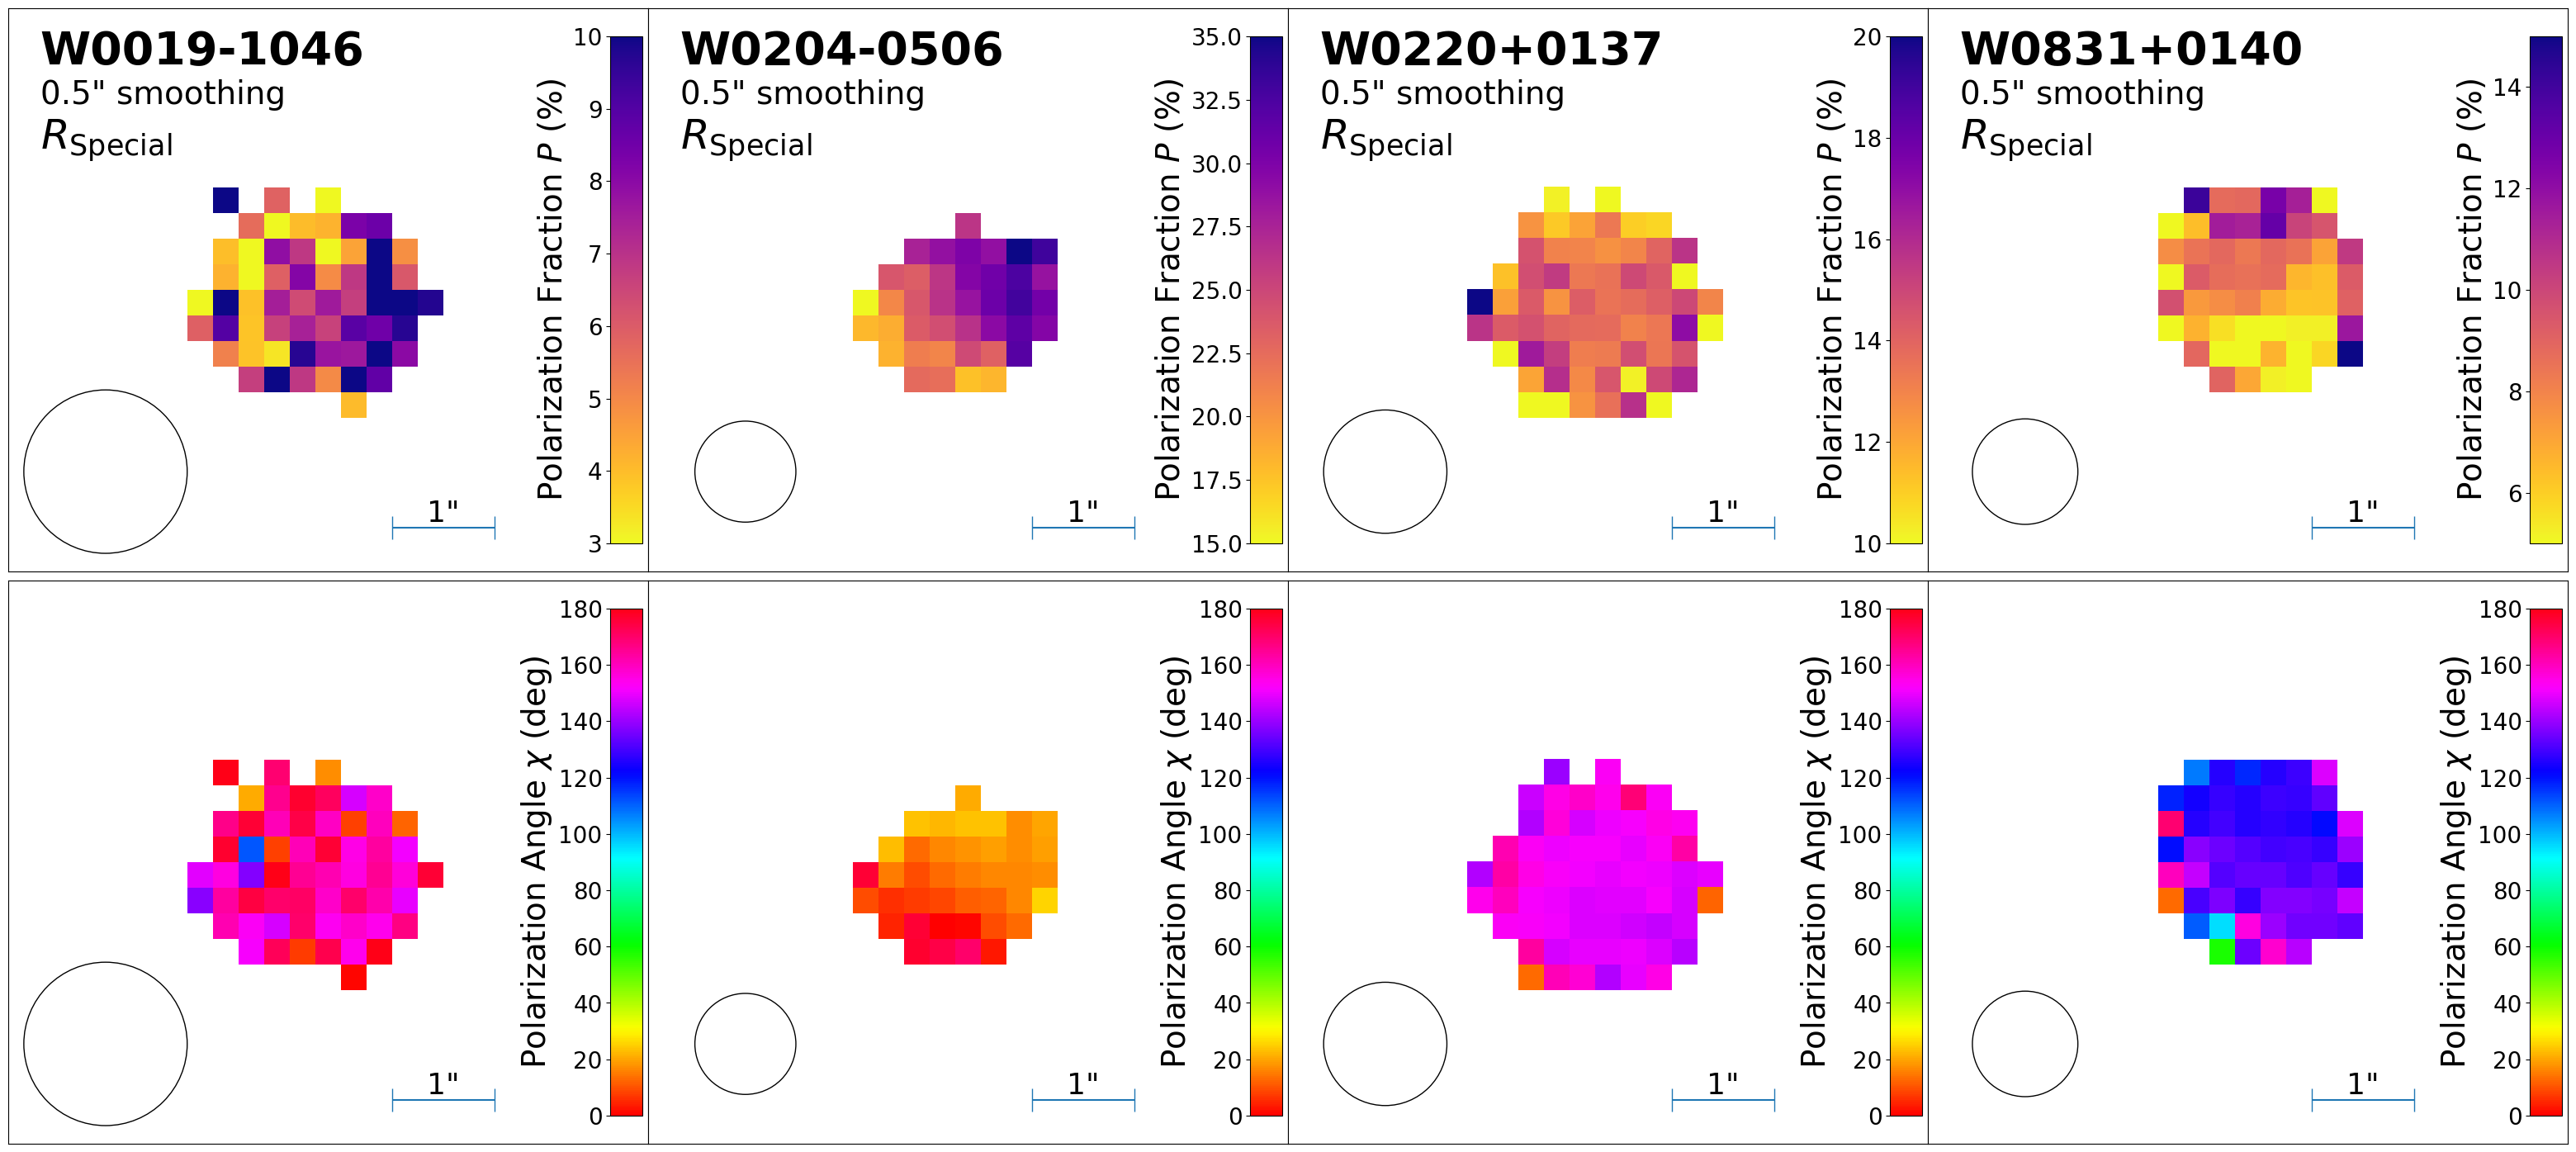

In [11]:
make_plot(objects, blurr_PSF_FWHM=0.5, size=22, output_fname="Blurred_0.5_Resolution_new_HDs_2D_pol.png", bands=bands)

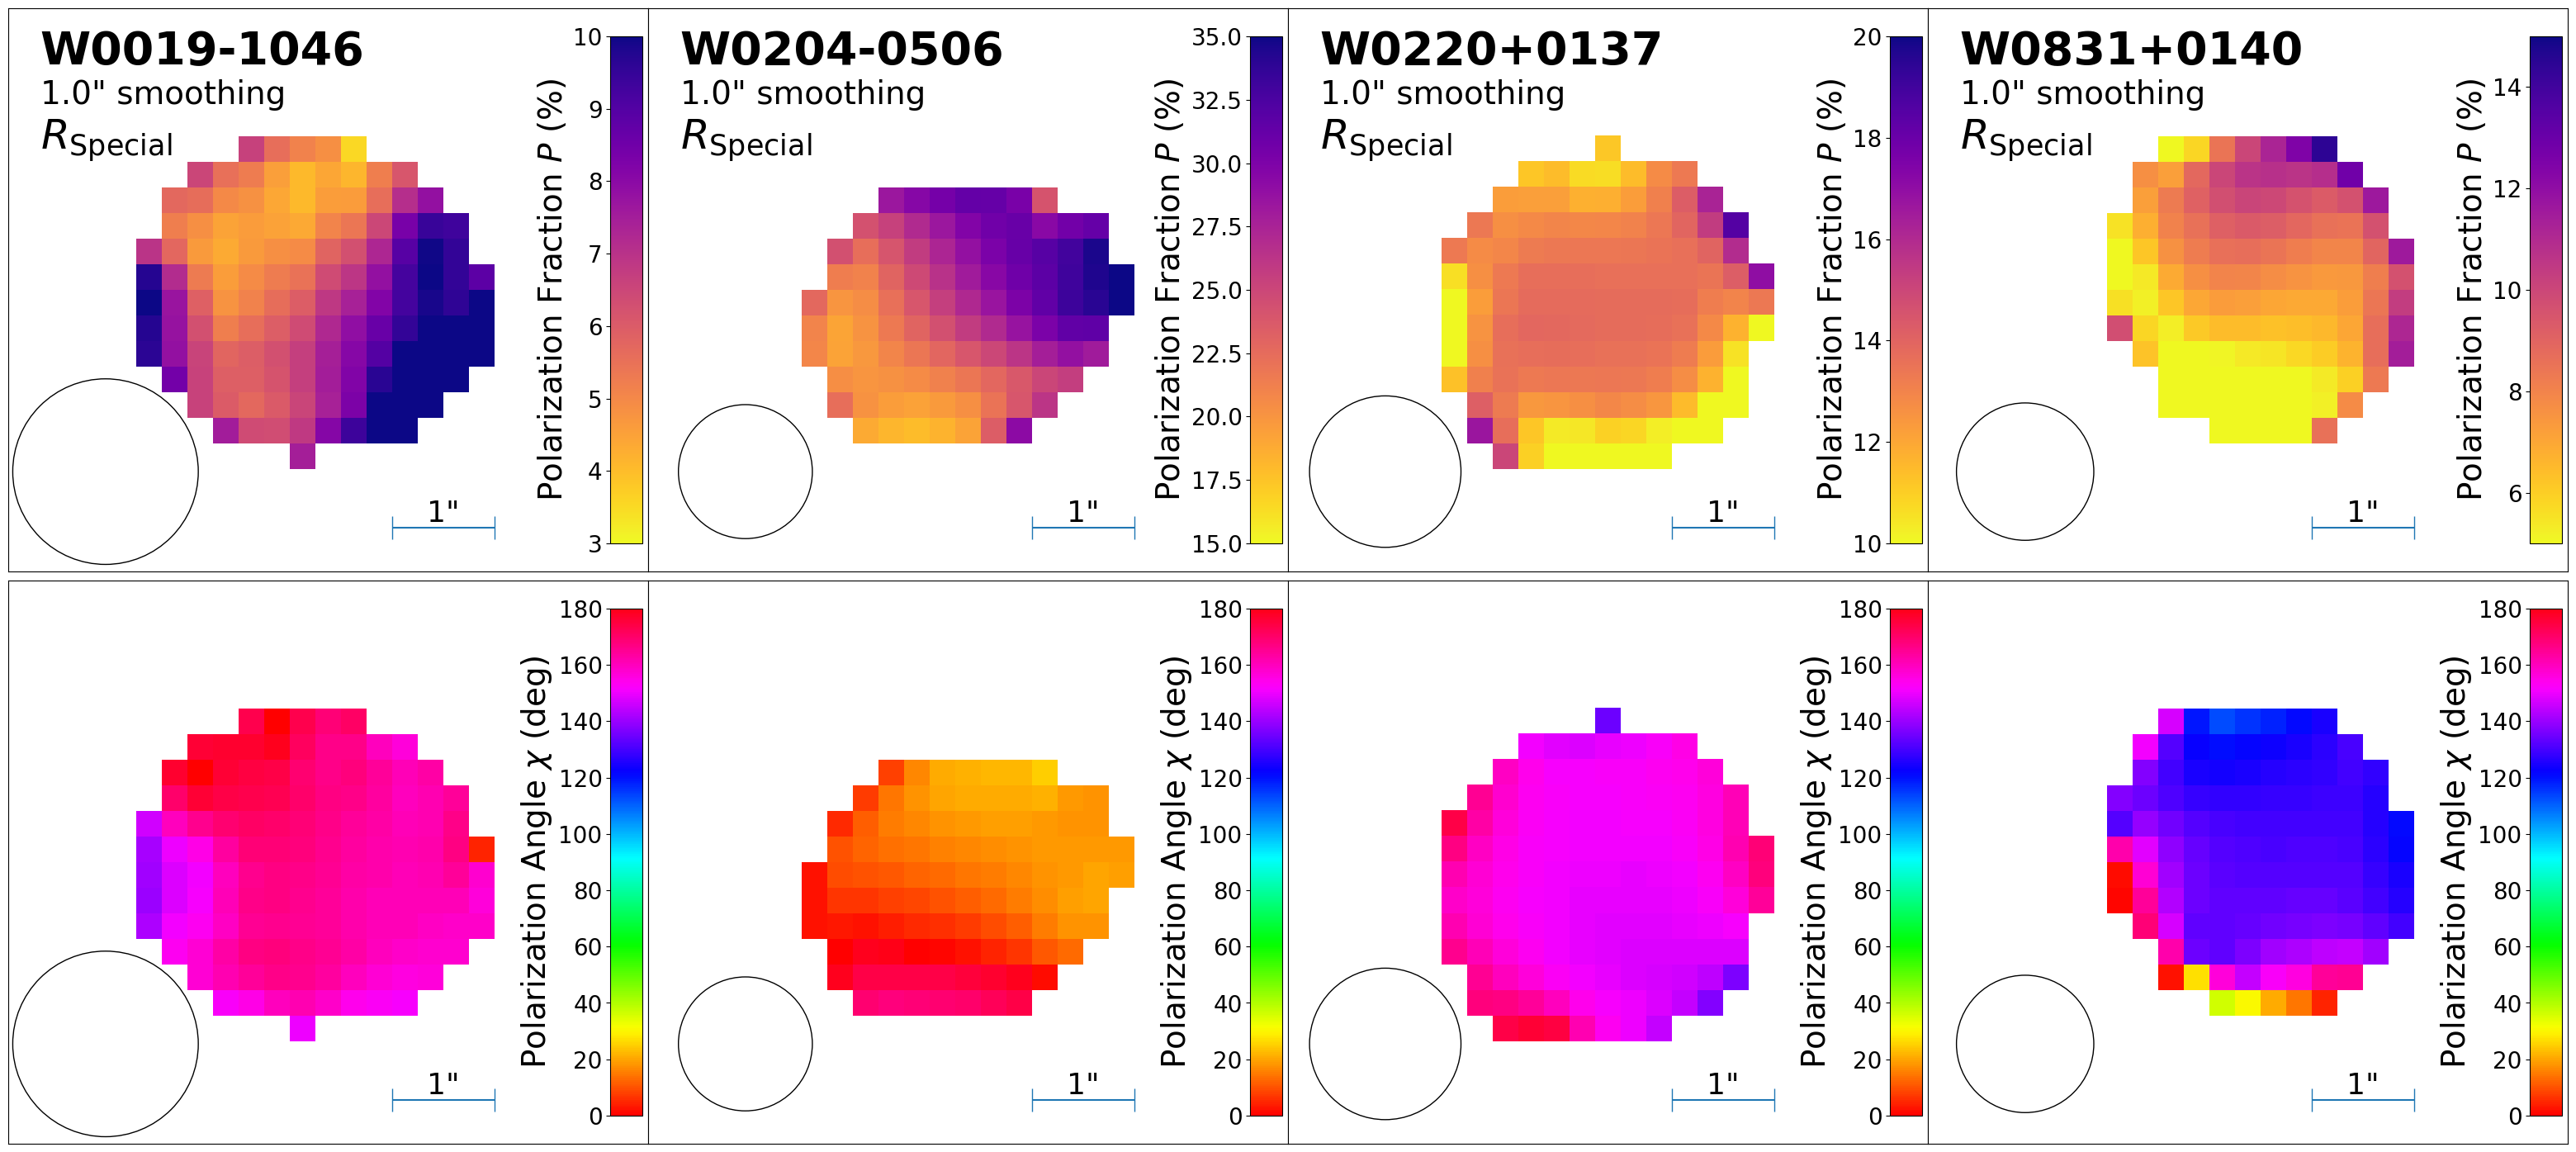

In [12]:
make_plot(objects, blurr_PSF_FWHM=1.0, size=22, output_fname="Blurred_1.0_Resolution_new_HDs_2D_pol.png", bands=bands)

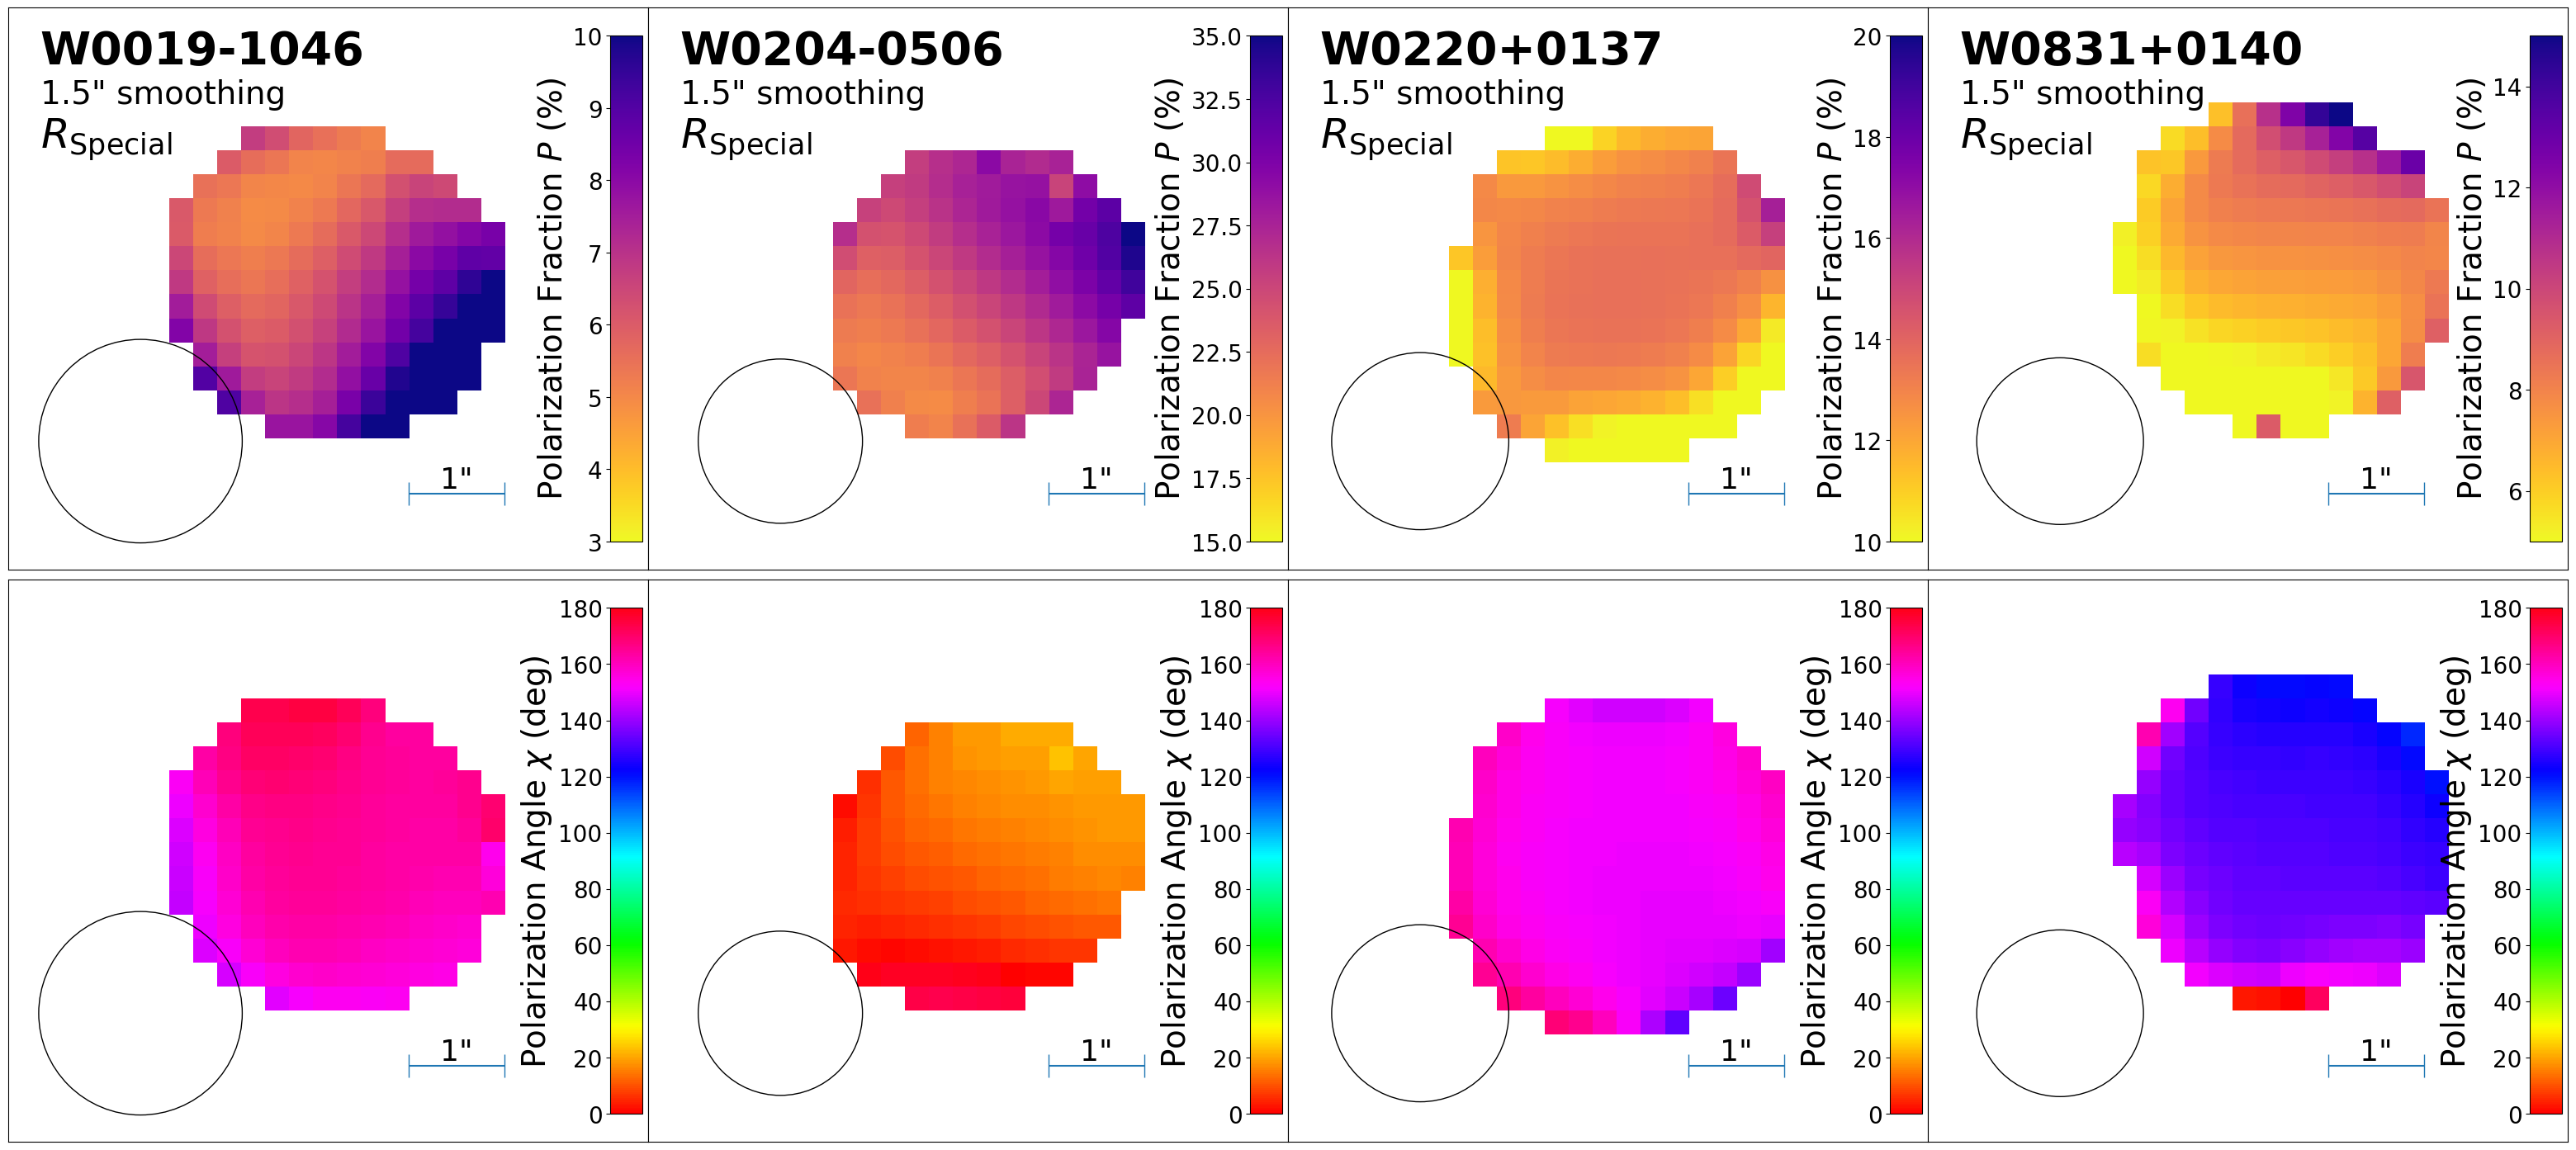

In [13]:
make_plot(objects, blurr_PSF_FWHM=1.5, size=22, output_fname="Blurred_1.5_Resolution_new_HDs_2D_pol.png", bands=bands)

## W0116-0505

In [14]:
objects = [
    "W0116-0505",
]
bands = ["I_BESS", "R_SPECIAL", "v_HIGH"]

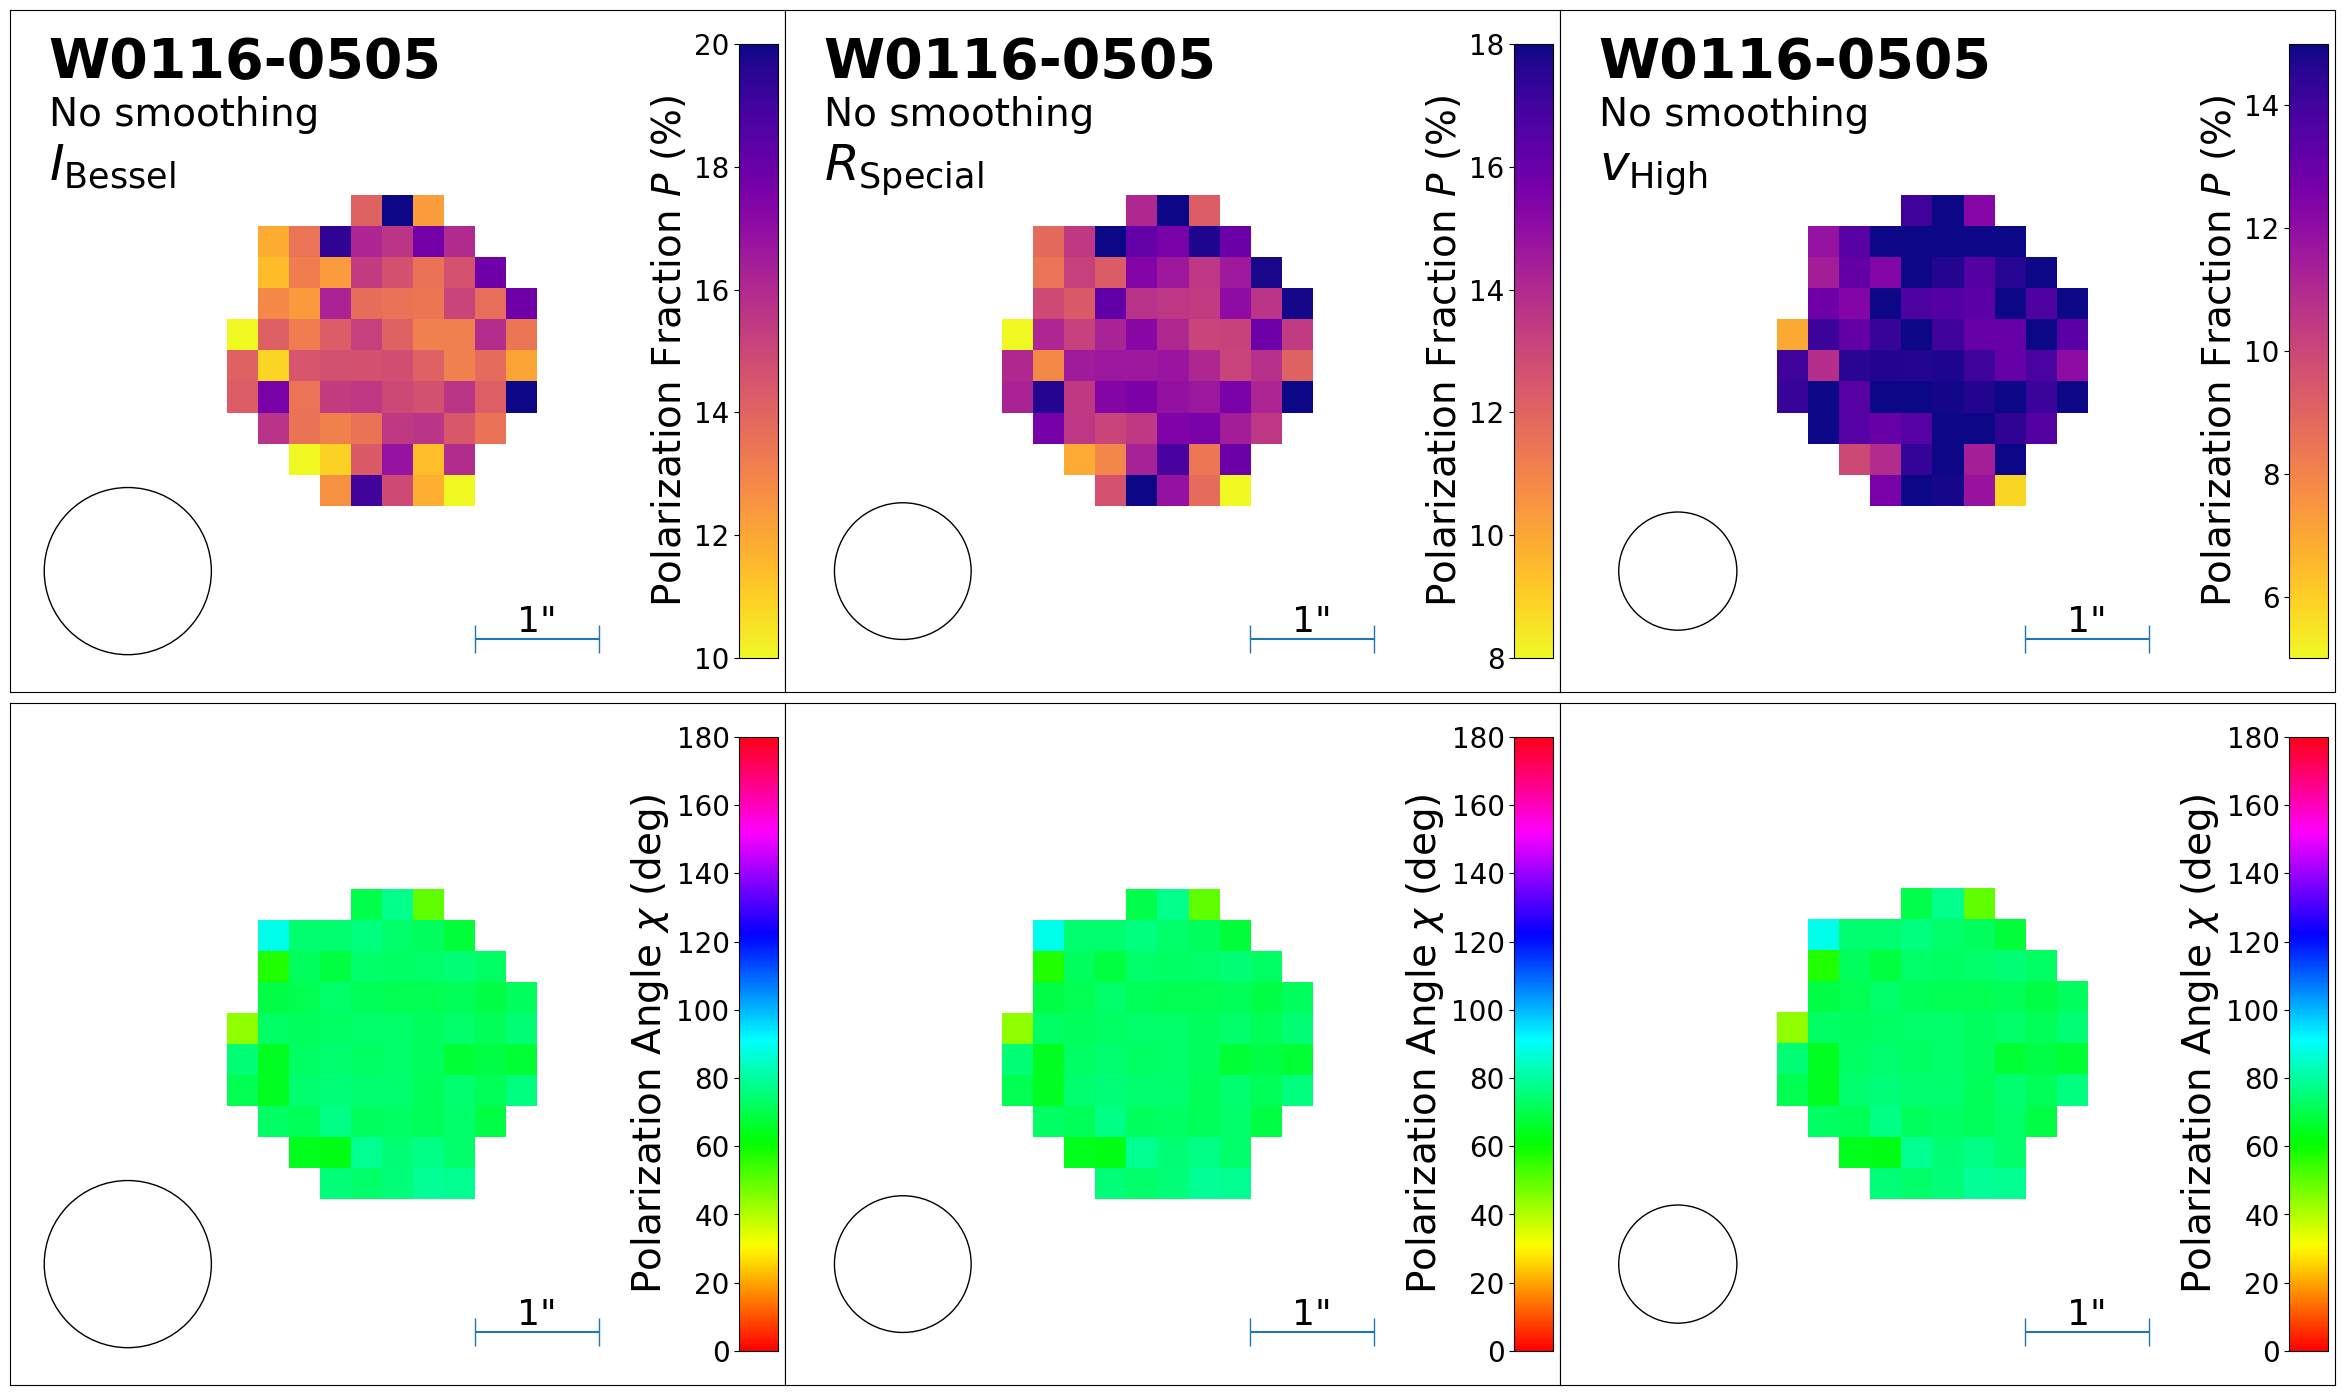

In [15]:
make_plot(objects, size=22, output_fname="Original_Resolution_W0116-0505_2D_pol.png", bands=bands, figsize=(30,18))

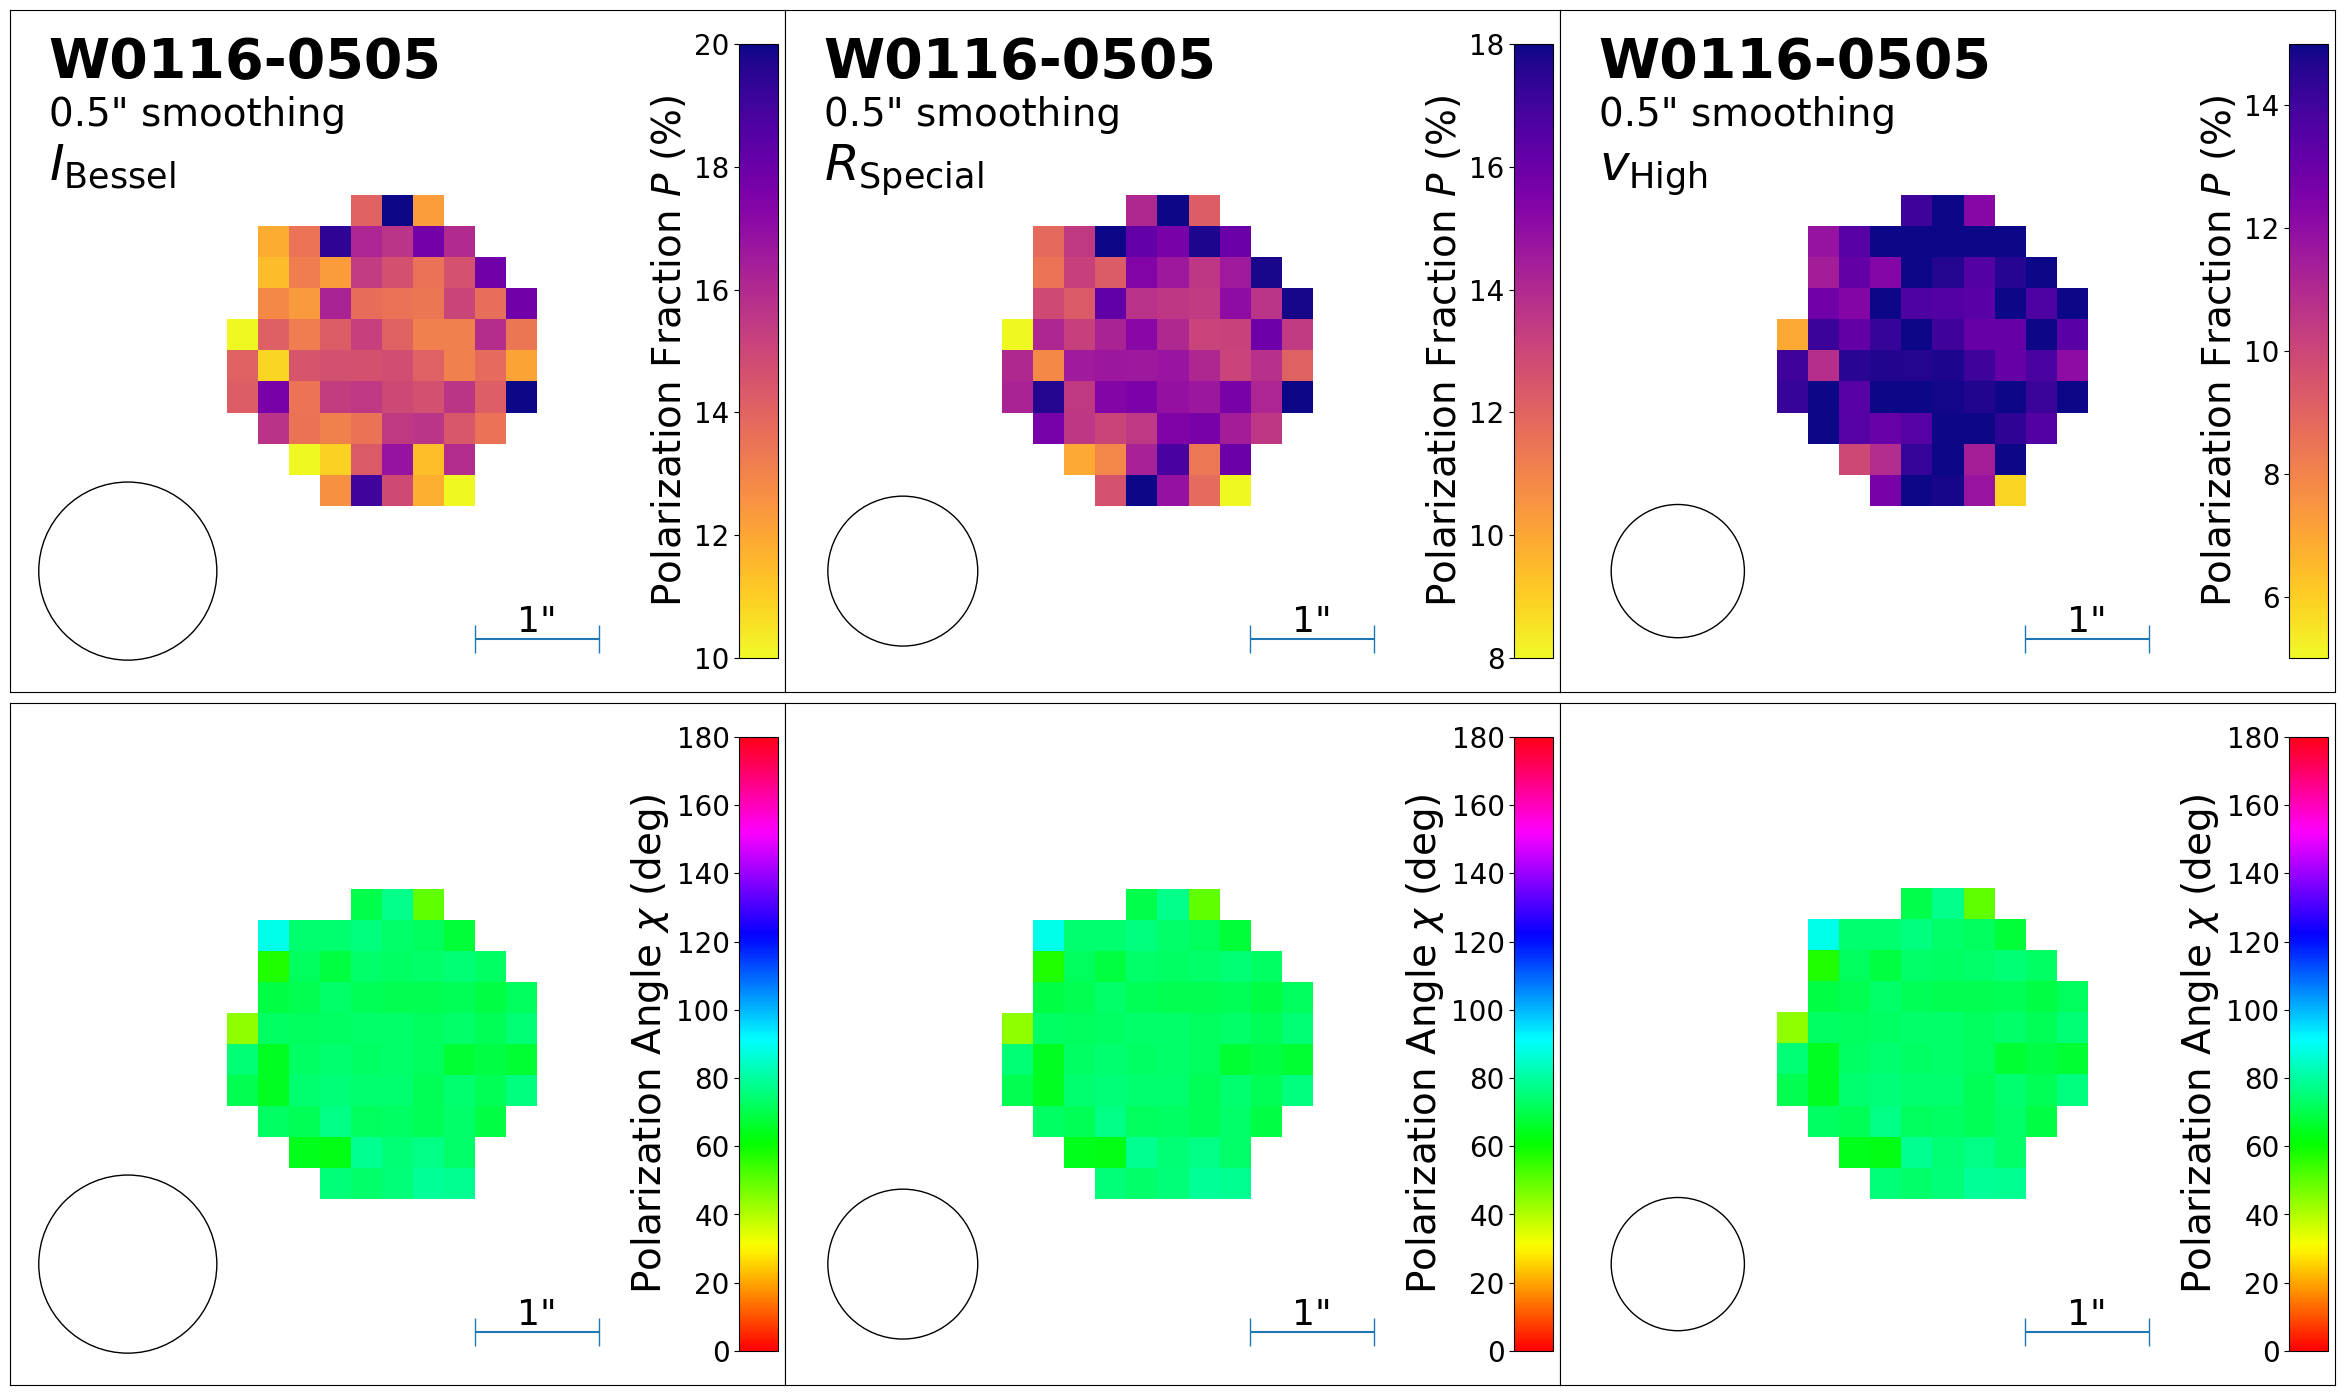

In [16]:
make_plot(objects, blurr_PSF_FWHM=0.5, size=22, output_fname="Blurred_0.5_Resolution_W0116-0505_2D_pol.png", bands=bands, figsize=(30,18))

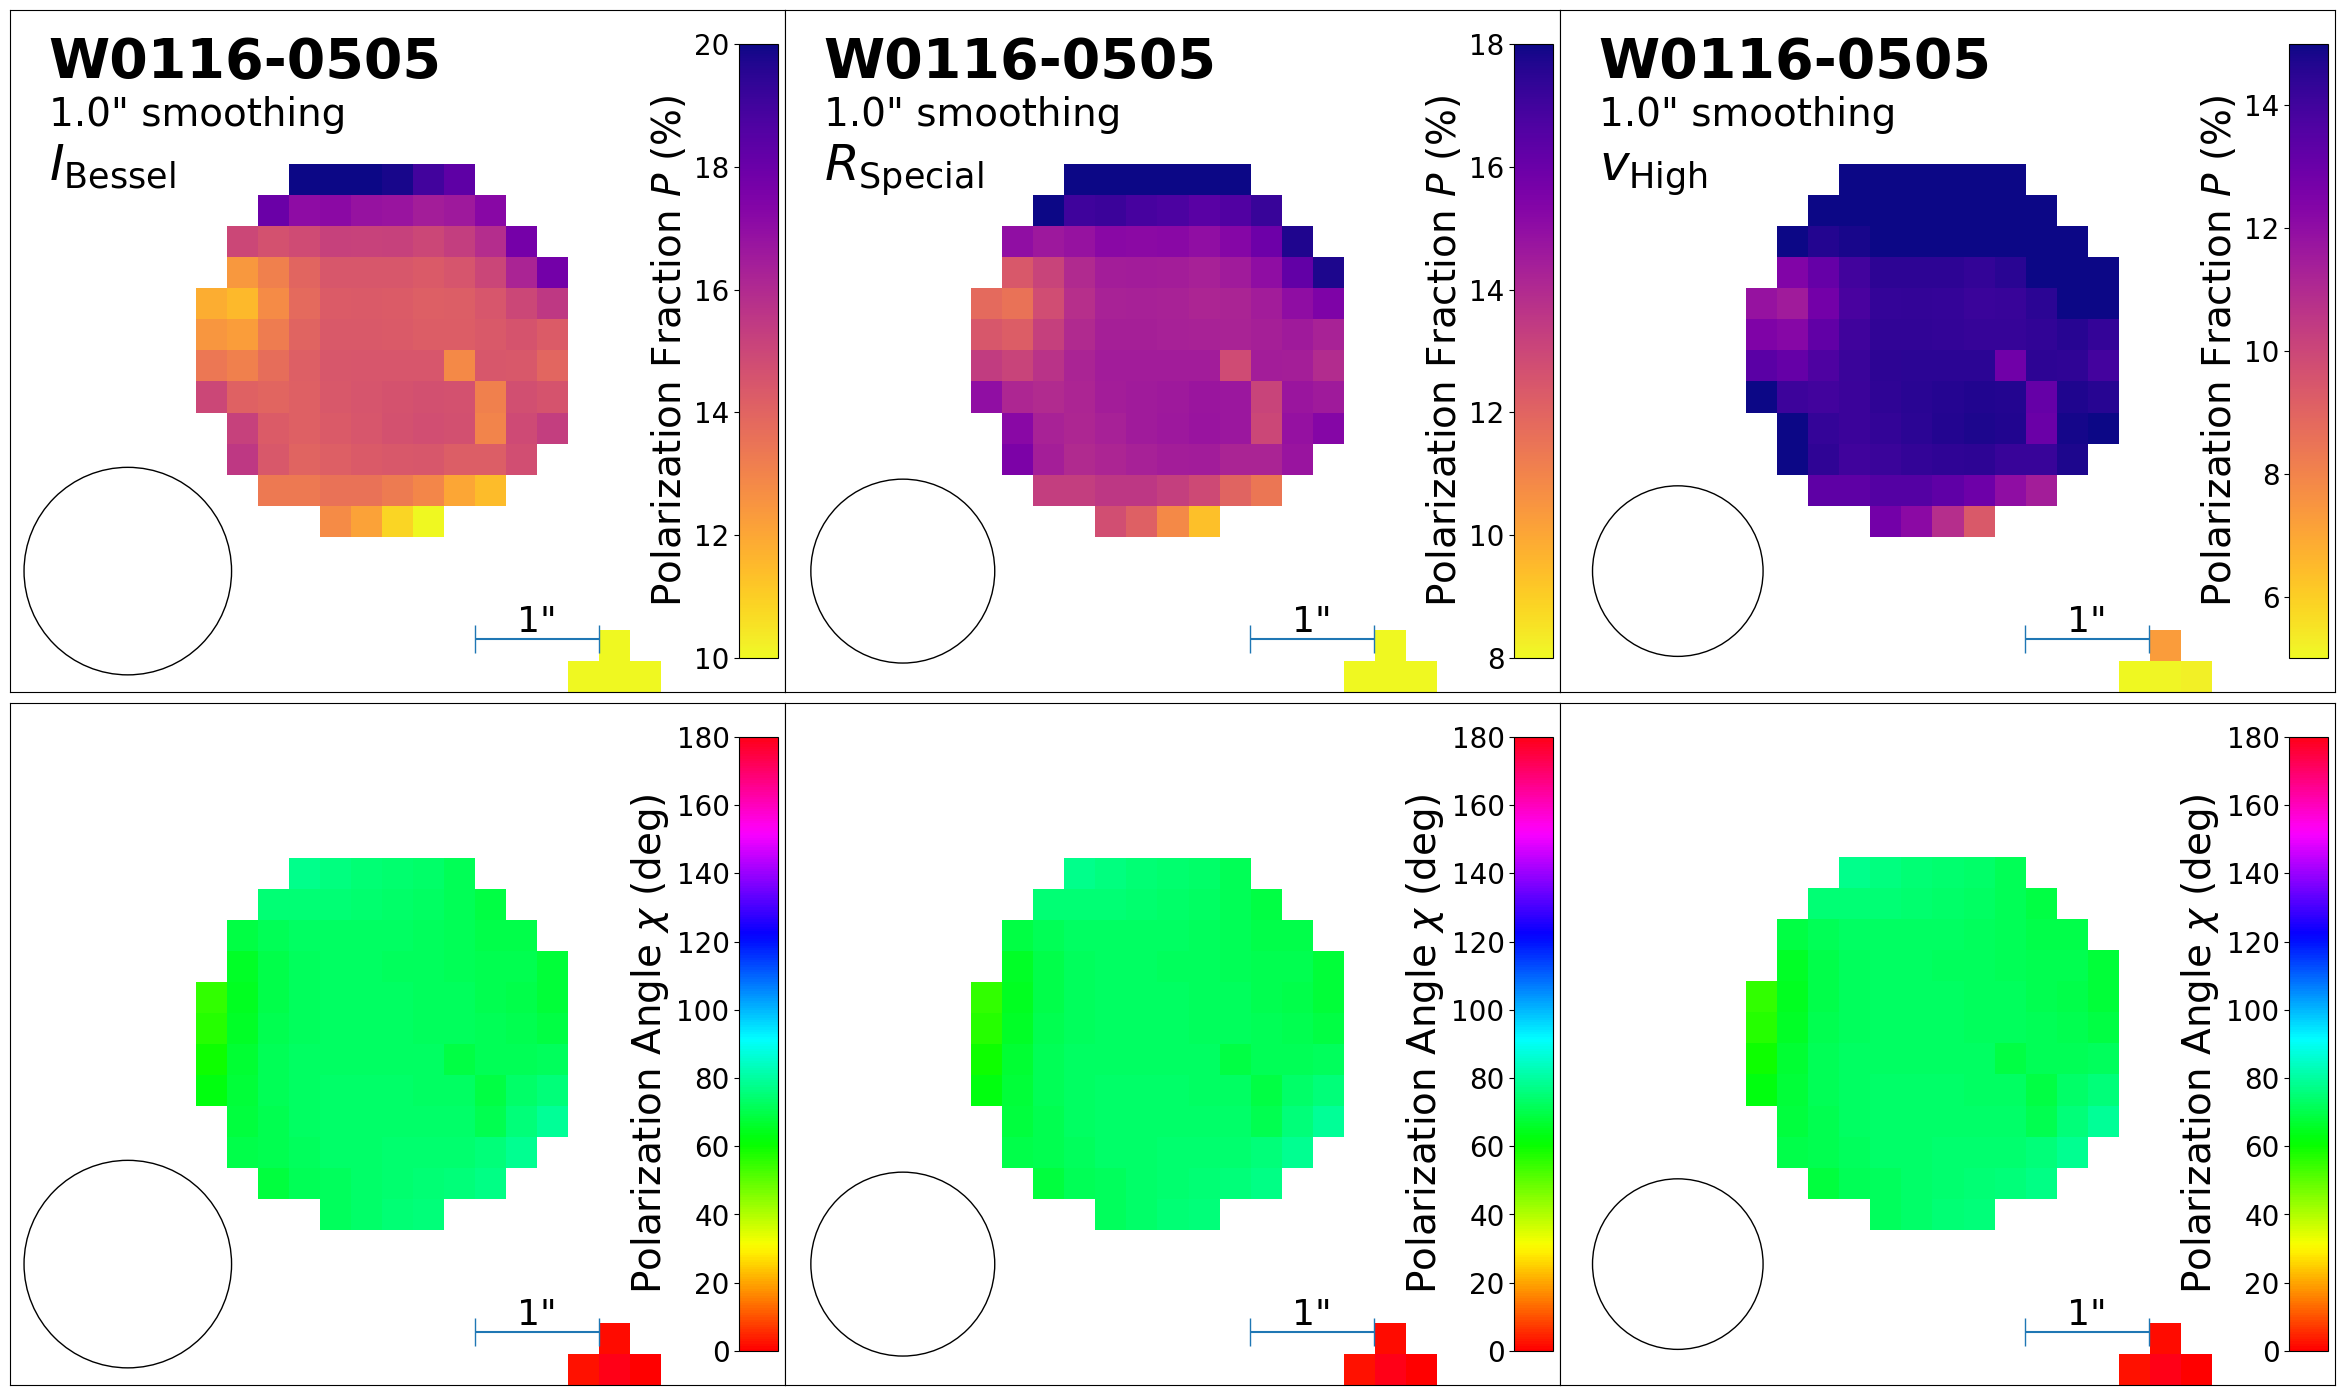

In [17]:
make_plot(objects, blurr_PSF_FWHM=1.0, size=22, output_fname="Blurred_1.0_Resolution_W0116-0505_2D_pol.png", bands=bands, figsize=(30,18))

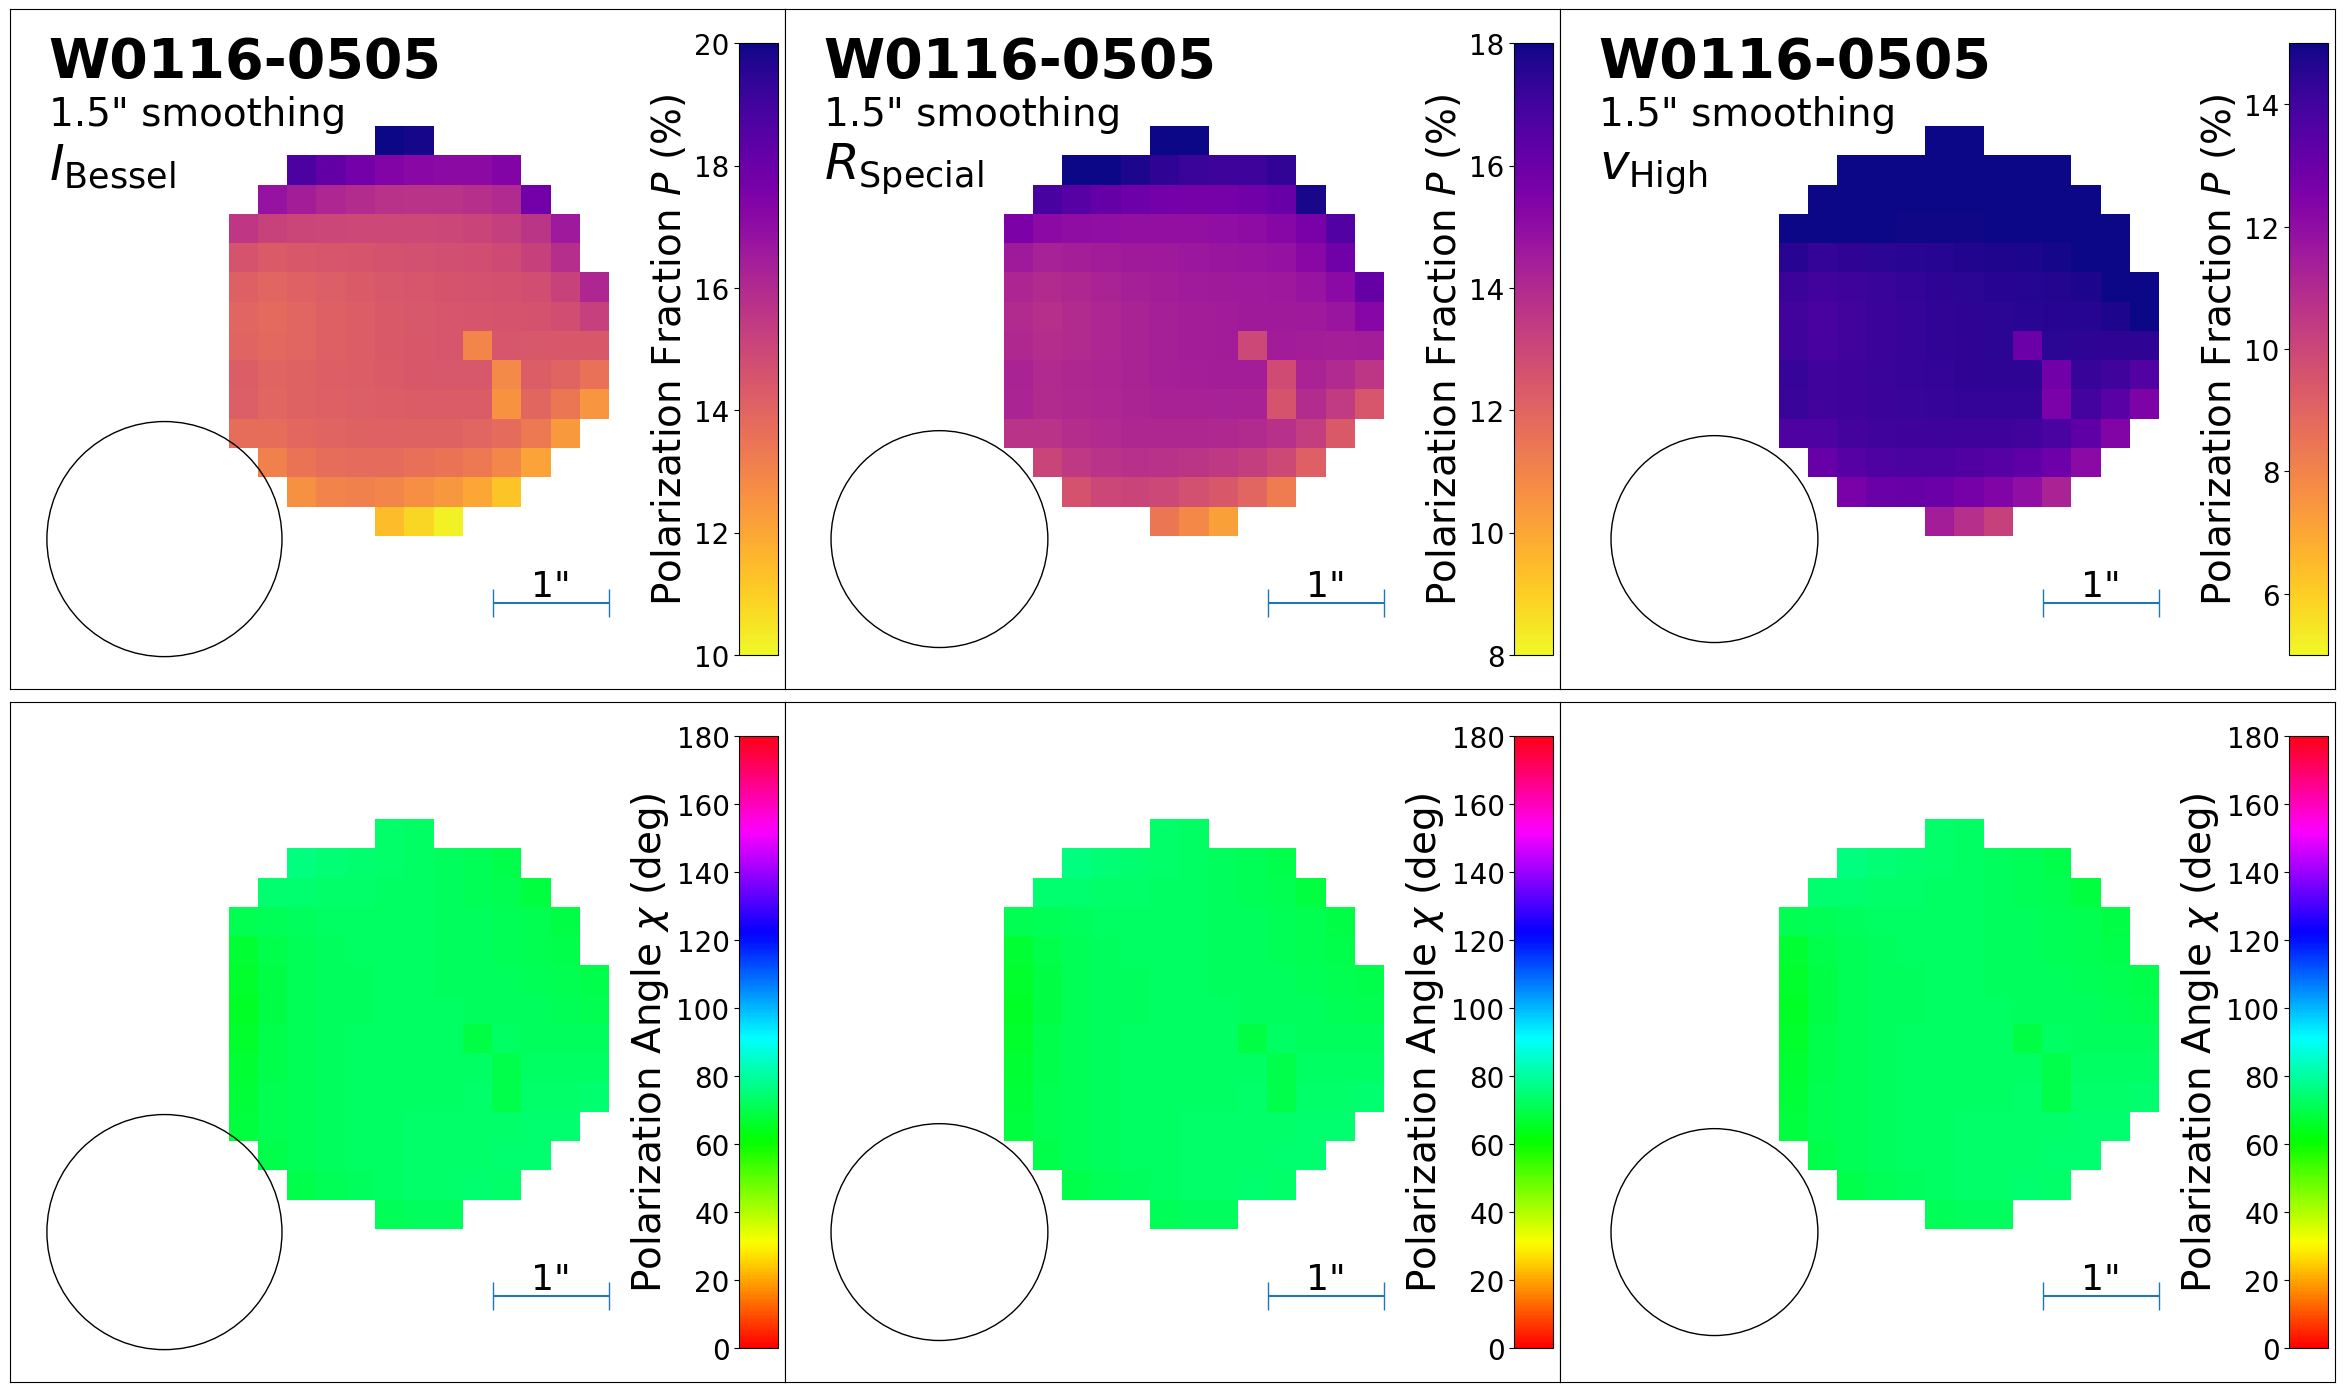

In [18]:
make_plot(objects, blurr_PSF_FWHM=1.5, size=22, output_fname="Blurred_1.5_Resolution_W0116-0505_2D_pol.png", bands=bands, figsize=(30,18))